# Sistemas Dinâmicos e Controlo - Projeto

In [196]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import StateSpace, lsim, step

In [197]:
m = 1.5 * 10 ** -1 # motorcycle mass
g = 9.81 # gravity
h = 8.0 * 10 ** -1 # height of center of mass
I = 1.5 * 10 ** -2 # moment of inertia

### Ex. 1

$$ I \ddot{\theta} = mgh \cdot sin(\theta) + \tau $$

At small angles $ sin(\theta) \approx \theta $.

$$ I \ddot{\theta} = mgh \cdot \theta + \tau $$

$$ \ddot{\theta} = \frac{mgh \cdot \theta}{I} + \frac{\tau}{I} $$

$$ x = \begin{bmatrix} 
 \theta \\
 \dot{\theta} \\
\end{bmatrix} \Leftrightarrow \dot{x} = \begin{bmatrix} 
 \dot{\theta} \\
 \ddot{\theta} \\
\end{bmatrix} \Leftrightarrow \dot{x} = \begin{bmatrix} 
 \dot{\theta} \\
 \frac{mgh}{I}\cdot \theta + \frac{\tau}{I} \\
\end{bmatrix} \Leftrightarrow \dot{x} = \begin{bmatrix} 
 \dot{\theta} \\
 \frac{mgh}{I}\cdot \theta \\
\end{bmatrix} + \begin{bmatrix}
0 \\
\frac{\tau}{I}
\end{bmatrix} u \Leftrightarrow \dot{x} = \begin{bmatrix} 
 0 & 1 \\
 \frac{mgh}{I}  & 0\\
\end{bmatrix} \begin{bmatrix}
 \theta \\
 \dot{\theta}
\end{bmatrix} + \begin{bmatrix}
0 \\
\frac{\tau}{I}
\end{bmatrix} u $$

Since $ u = \tau $:

$$
\dot{x} = \begin{bmatrix} 
 0 & 1 \\
 \frac{mgh}{I}  & 0\\
\end{bmatrix} \begin{bmatrix}
 \theta \\
 \dot{\theta}
\end{bmatrix} + \begin{bmatrix}
0 \\
I
\end{bmatrix} u $$

$$ y = C \cdot x \Leftrightarrow y = C \cdot \begin{bmatrix}
\theta \\ \dot \theta
\end{bmatrix} \Leftrightarrow y = \begin{bmatrix}
1 & 0 \\
0 & 1 \\
\end{bmatrix} \cdot \begin{bmatrix}
\theta \\ \dot \theta
\end{bmatrix} \Leftrightarrow C = \begin{bmatrix}
1 & 0 \\
0 & 1 \\
\end{bmatrix} $$
 


In [198]:
A = np.array([[0, 1],
              [m * g * h / I, 0]])
B = np.array([[0],
              [1 / I]])
C = np.array([[1, 0]])
D = np.array([[0]])
print("Matrix A: ", A)
print("Matrix B: ", B)
print("Matrix C: ", C)

Matrix A:  [[ 0.    1.  ]
 [78.48  0.  ]]
Matrix B:  [[ 0.        ]
 [66.66666667]]
Matrix C:  [[1 0]]


### Ex.2

Controlability Matrix:

$$ Q = \begin{bmatrix} B & AB & A^{2}B & ... & A^{n-1}B \end{bmatrix} $$

$ |Q| = 0 $, the system is controllable, $ |Q| \neq 0 $, the system is not controllable.

In [199]:
n = 2
AB = A @ B
Q = np.zeros((n,n))
Q[0,0] = B[0,0]
Q[1,0] = B[1,0]
Q[0,1] = AB[0,0]
Q[1,1] = AB[1,0]

In [200]:
print("Controlability Matrix: ", Q)
print("Determinant: ", np.linalg.det(Q))
print("Rank: ", np.linalg.matrix_rank(Q))

if np.linalg.det(Q) == 0:
    print(" The system is controllable")
else:
    print("The system is not controllable")

if np.linalg.matrix_rank == n:
    print("The system is controllable")
else:
    print("The system is not controllable")

Controlability Matrix:  [[ 0.         66.66666667]
 [66.66666667  0.        ]]
Determinant:  -4444.444444444446
Rank:  2
The system is not controllable
The system is not controllable


Observability Matrix:


$$ O = \begin{bmatrix} C \\ CA \\ CA^{2} \\ ... \\ CA^{n-1} \end{bmatrix} $$

$rank(O) = n$ => Observable

In [201]:
CA = C @ A
O = np.zeros((n, n))

O[0,0] = C[0][0]
O[0,1] = C[0][1]
O[1,0] = CA[0][0]
O[1,1] = CA[0][1]

print("Observability Matrix: ", O)
print("Determinant: ", np.linalg.det(O))
print("Rank: ", np.linalg.matrix_rank(O))

if np.linalg.matrix_rank == n:
    print("The system is observable")
else:
    print("The system is not observable")

Observability Matrix:  [[1. 0.]
 [0. 1.]]
Determinant:  1.0
Rank:  2
The system is not observable


### Ex.3

#### a) Step input, u = 10**-2, and non-null initial conditions, x0 = [x01, x02]

#### b) Null input, u = 0, and non-null initial conditions, x0 = [x01, x02]

In [202]:
# Time Response
t = np.linspace(0, 1, 50)
u = 10**-2 * np.ones_like(t)  # Input matrix
x0 = [0, 0]                  # Initial conditions
D = np.zeros((1, 1))
system = StateSpace(A, B, C, D)

# Simulate the system
time, y1, x = lsim(system, u, t, x0)

t = np.linspace(0, 1, 50)
u = 0 * np.ones_like(t) # transformar u em matriz
x0 = [0.5, 0.5] # condicoes iniciais
D = np.zeros((1, 1))
system = StateSpace(A, B, C, D)

# lsim -> simulate output of a continuous-time linear system
time, y2, x = lsim(system, u, t, X0=x0)

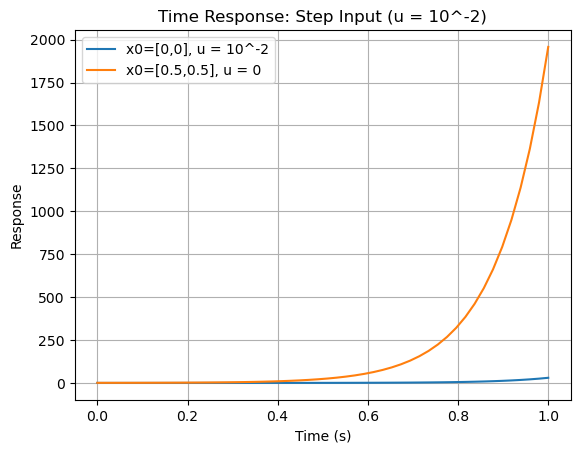

In [203]:
plt.plot(t, y1, label="x0=[0,0], u = 10^-2")
plt.plot(t, y2, label="x0=[0.5,0.5], u = 0")
plt.title("Time Response: Step Input (u = 10^-2)")
plt.xlabel("Time (s)")
plt.ylabel("Response")
plt.legend()
plt.grid()

## Design of Controllers in State Space

### Ex.4